In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
import sklearn.model_selection as ms
import scipy.stats as stats
import scipy
#print (scipy.__version__)

//TODO
+ T-Test da fare bene
+ regressione lineare/previsione(?)
+ aggiungere qualcosa ai titoli
+ aggiungere qualcosa agli autori
+ portare tutto su windows

# **Dataset Amazon Top 50 Bestselling Books 2009 - 2022**


Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

In questo notebook studieremo le preferenze degli utenti e gli effetti che la pandemia ha avuto sulla vendita di libri su amazon, utilizzando quindi i bestseller

Il notebook è strutturato in tre punti principali:
+ numero di reviews prima e dopo il 2020
+ il genere preferito dall'utenza
+ la variazione del prezzo 
+ studio del titolo

Per prima cosa facciamo qualche operazione preliminare per conoscere meglio il dataset:

In [2]:
book = pd.read_csv('bestsellers.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

##### Ragioniamo adesso sul significato di ogni colonna e sul loro livello

- *Name*: il nome del libro (qualitativo)
- *Author*: l'autore del libro (qualitativo)
- *User Rating*: il punteggio di ogni libro
- *Reviews*: il numero di recensioni di quel determinato libro
- *Price*: prezzo del libro
- *Year*: anno di pubblicazione del libro
- *Genre*: genere del libro (valore "booleano")

Estraiamo informazioni di base sul nostro dataset.

In [3]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [4]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [5]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Tutte le caratteristiche sono abbastanza significative, anche quelle qualitative come il nome e l'autore e quindi non credo sia necessario eliminare delle colonne

Adesso controlliamo che non ci siano elementi duplicati nel nostro dataset:

In [6]:
book['Name'].describe()

count                                                   700
unique                                                  441
top       Publication Manual of the American Psychologic...
freq                                                     10
Name: Name, dtype: object

Come possiamo vedere sono presenti numerosi libri duplicati nel nostro dataset, per il fatto che un libro è stato bestseller per più anni 

Dei nostri 700 elementi solo 441 sono singoli

In [62]:
duplicate_book = book['Name'].describe()['top']
book_is_duplicate = book['Name'] == duplicate_book

In [63]:
filtered_dataframe = book[book_is_duplicate]
filtered_dataframe

,Name,Author,User Rating,Reviews,Price,Year,Genre
22,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2009,Non Fiction
70,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2010,Non Fiction
120,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2011,Non Fiction
170,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2012,Non Fiction
225,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2013,Non Fiction
276,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2014,Non Fiction
329,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2015,Non Fiction
379,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2016,Non Fiction
425,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2017,Non Fiction
479,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2018,Non Fiction


Ad esempio questo libro della American Psycological Association è presente ben 10 volte nel dataset, perchè è stato best seller per molti anni consecutivi

Adesso calcoliamo la correlazione tra le feature quantitative del nostro dataset:

In [10]:
book.corr(method='pearson')

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.080423,-0.157253,0.286601
Reviews,0.080423,1.000000,-0.114554,0.494279
Price,-0.157253,-0.114554,1.000000,-0.155266
Year,0.286601,0.494279,-0.155266,1.000000


La correlazione tra dati che si nota maggiormente è quella Reviewes - Year e quella User Rating - Year.

## REVIEWS NEGLI ANNI

Applicando un semplice grafico lineare si può vedere come proprio tra il 2019 e il 2020 c'è stato un vertiginoso inalzamento delle reviews

In [12]:
annual_reviews = book.groupby('Year')[['Reviews']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_reviews)

    Year   Reviews
0   2009   4710.12
1   2010   5479.62
2   2011   8100.82
3   2012  13090.92
4   2013  13098.14
5   2014  15859.94
6   2015  14233.38
7   2016  14196.00
8   2017  12888.40
9   2018  13930.42
10  2019  15898.34
11  2020  52349.94
12  2021  44859.48
13  2022  40877.22


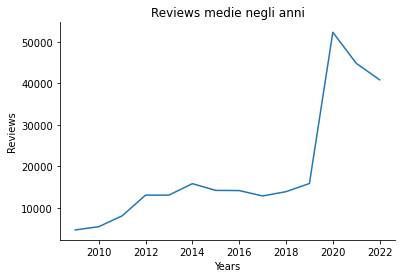

In [51]:
fig, ax = plt.subplots()
plt.plot(annual_reviews['Year'], annual_reviews['Reviews'])
plt.title("Reviews medie negli anni")
plt.ylabel("Reviews")
plt.xlabel("Years")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<AxesSubplot:title={'center':'Reviews medie negli anni'}, xlabel='Year', ylabel='Reviews'>

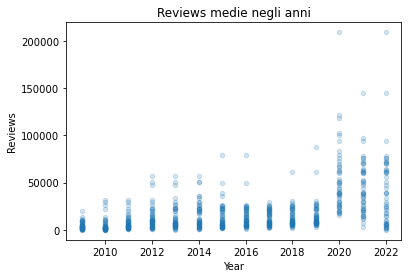

In [53]:
book.plot(kind= 'scatter', x= 'Year', y= 'Reviews', title= 'Reviews medie negli anni', alpha= 0.2)

Questo è un chiaro esempio di come la pandemia ha effettivamente cambiato le abitudini.

A partire infatti dal 2020 c'è un aumento vertiginoso del numero di reviews, che può anche essere legato al numero di copie comprate (dato non presente purtroppo nel dataset)

Come possiamo vedere nel 2019 il numero medio di reviews si aggira attorno alle 8000 mentre nel 2020 il numero medio è 42000

Questo aumento è così improvviso e corposo non può essere ignorato, e deve essere sicuramente collegato ad un evento d'impatto come la pandemia.

Come immaginabile infatti, con la fine del lockdown più pesante nel 2020 il numero di reviews si è, pur restando molto alto, ridimensionato

Infine guardiamo se le reviews sono collegate in qualche modo alla valutazione del libro.

Per farlo utilizziamo un boxplot

<AxesSubplot:title={'center':'Reviews'}, xlabel='User Rating'>

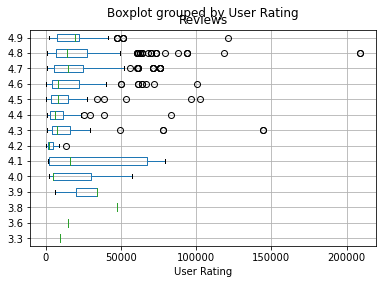

In [15]:
book.boxplot(column='Reviews', by='User Rating', vert = False)

In media più alto è il valore più reviews ci sono

## STUDIO SUL GENERE PREFERITO

Le abitudini dei lettori sono cambiate con la pandemia? Anche se i dati sono un po' vaghi(distinzione solo tra Fiction e Non Fiction) possiamo vedere se le preferenze nei bestseller sono cambiate

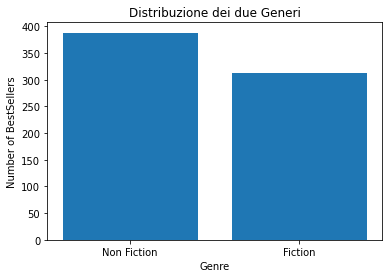

In [54]:
counts = book["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.title("Distribuzione dei due Generi")
plt.ylabel("Number of BestSellers")
plt.xlabel("Genre")
plt.show()

Come possiamo vedere dal grafico c'è una predominanza (anche se leggera) del genere "Non Fiction" rispetto a quello fiction

([<matplotlib.patches.Wedge at 0x7fc310bb0490>,
 [Text(-0.1866898666921769, 1.0840419243158714, 'Fiction'),
  Text(0.18668986669217674, -1.0840419243158714, 'Non Fiction')],
 [Text(-0.10183083637755103, 0.5912955950813843, '55.4%'),
  Text(0.10183083637755094, -0.5912955950813843, '44.6%')])

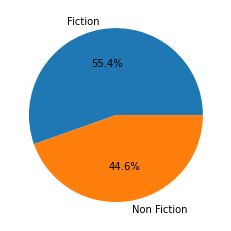

In [17]:
plt.pie(book['Genre'].value_counts(),labels=['Fiction','Non Fiction'],autopct='%.1f%%')

[Text(0.5, 1.0, 'genre distribution')]

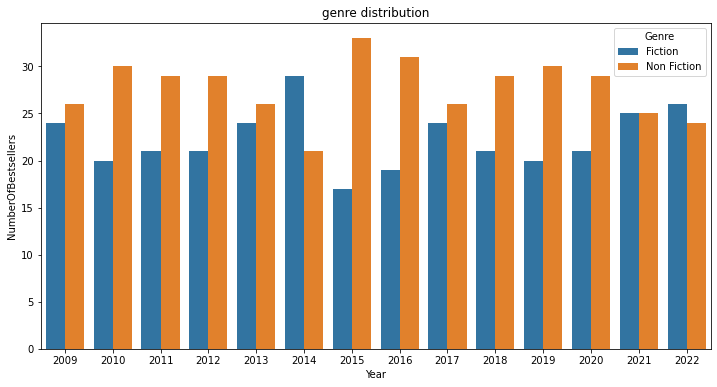

In [18]:
df=book.groupby(['Genre', 'Year']).size().reset_index(name='NumberOfBestsellers')
plt.figure(figsize=(12, 6))
sb.barplot(x='Year', y='NumberOfBestsellers', hue='Genre', data=df).set(title='genre distribution')

Attraverso la libreria seaborn possiamo vedere come c'è una distribuzione abbastanza casuale dei due generi nei diversi anni anche se quello "non fiction" predomina quasi sempre

Negli ultimi anni c'è stata una "risalita" del genere "fiction" ma non è per forza collegato alla pandemia visto che anche in altri anni (2014) c'era stata una predominanza dei libri "fiction"

Come possiamo notare dall'ultimo grafico in tutti gli anni c'è stata una predominanza del genere fiction a discapito di quello "non Fiction" ad eccezione del 2014.

Andiamo quindi a vedere cosa è successo in quell'anno.

In [58]:
Year_2014 = book[book["Year"] == 2014]
Fiction_2014 = Year_2014[Year_2014["Genre"]=="Fiction"]
Fiction_2014

,Name,Author,User Rating,Reviews,Price,Year,Genre
250,A Game of Thrones / A Clash of Kings / A Storm...,George R. R. Martin,4.7,19735,30,2014,Fiction
251,All the Light We Cannot See,Anthony Doerr,4.6,36348,14,2014,Fiction
254,Diary of a Wimpy Kid: The Long Haul,Jeff Kinney,4.8,6540,22,2014,Fiction
255,Divergent,Veronica Roth,4.6,27098,15,2014,Fiction
256,Divergent / Insurgent,Veronica Roth,4.5,17684,6,2014,Fiction
258,Frozen (Little Golden Book),RH Disney,4.7,3642,0,2014,Fiction
259,Gone Girl,Gillian Flynn,4.0,57271,9,2014,Fiction
263,If I Stay,Gayle Forman,4.3,7153,9,2014,Fiction
265,JOURNEY TO THE ICE P,RH Disney,4.6,978,0,2014,Fiction
269,Little Blue Truck,Alice Schertle,4.9,1884,0,2014,Fiction


Come possiamo vedere nel 2014 i libri Fiction sono stati molti più di quelli non Fiction.

In quell'anno del resto sono stati venduti su amazon libri molto famosi ancora oggi

Guardiamo adesso le reviews e il rating in base al genere.

In [19]:
book.groupby('Genre')[['Reviews']].mean().reset_index()

,Genre,Reviews
0,Fiction,24034.105769
1,Non Fiction,15412.360825


Il numero di reviews medio dei libri Fiction è nettamente maggiore e come già detto in precedenza questo potrebbe essere strettamente collegato al numero di copie vendute.
Potrebbero quindi esserci un numero minore di bestseller di tipo fiction ma con più copie vendute o comunque con più fan che hanno deciso di lasciare una recensione oltre che a comprare il libro

In [20]:
book.groupby('Genre')[['User Rating']].mean().reset_index()

,Genre,User Rating
0,Fiction,4.664103
1,Non Fiction,4.620361


Senza l'utilizzo di un grafico possiamo vedere lo user rating è pressochè uguale per ogni genere

T-test su differenza rating in base al genere
Ipotesi:

+ H0: Non ci sono differenze di valutazioni tra i due generi
+ H1: I due generi hanno valutazioni completamente differenti

Scegliamo un intervallo di confidenza pari a 0.95.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi $n > 30$;
2. Popolazione $N$ almeno dieci volte superiore al campione $N > 10*n$.

In [21]:
"""
Fiction_book = np.where(book['Genre']=="Fiction")[0]
print("Libri fiction: " + str(len(Fiction_book)))
Nfiction_book = np.where(book['Genre']=="Non Fiction")[0]
print("Libri Non Fiction: " + str(len(Nfiction_book)))
campione = book['User Rating'][Fiction_book].values[0:130].astype(int)
print("un campione di eta'dalla prima classe: " + str(campione.shape))
print("eta' media del campione: " + str(np.mean(campione)))
popolazione_restante = book['User Rating'][Fiction_book].values[0:130].astype(int)
print("popolazione restante dalla seconda e terza classe: " + str(popolazione_restante.shape))
print("e la loro eta' media: " + str(np.mean(popolazione_restante)))
"""

'\nFiction_book = np.where(book[\'Genre\']=="Fiction")[0]\nprint("Libri fiction: " + str(len(Fiction_book)))\nNfiction_book = np.where(book[\'Genre\']=="Non Fiction")[0]\nprint("Libri Non Fiction: " + str(len(Nfiction_book)))\ncampione = book[\'User Rating\'][Fiction_book].values[0:130].astype(int)\nprint("un campione di eta\'dalla prima classe: " + str(campione.shape))\nprint("eta\' media del campione: " + str(np.mean(campione)))\npopolazione_restante = book[\'User Rating\'][Fiction_book].values[0:130].astype(int)\nprint("popolazione restante dalla seconda e terza classe: " + str(popolazione_restante.shape))\nprint("e la loro eta\' media: " + str(np.mean(popolazione_restante)))\n'

In [22]:
t_statistic, p_value = stats.ttest_1samp(a= book['User Rating'][book['Genre']=="Fiction"], popmean= book['User Rating'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

3.0653679551757302
0.9988176846248612


come possiamo vedere il p-value è molto più grande rispetto al livello di significatività e per questo si può affermare che l'ipotesi H0 è confermata

## IL PREZZO

Un altro interessante studio che si può fare è quello sul prezzo: è aumentato negli anni? è diminuito? il genere incide sul prezzo del libro?

In [23]:
annual_price = book.groupby('Year')[['Price']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_price)

    Year  Price
0   2009  15.40
1   2010  13.48
2   2011  15.10
3   2012  15.30
4   2013  14.60
5   2014  14.64
6   2015  10.42
7   2016  13.18
8   2017  11.38
9   2018  10.52
10  2019  10.08
11  2020  10.46
12  2021  10.78
13  2022  12.46


Non sembra esserci stato un aumento significativo dei prezzi medi con l'avvento del covid

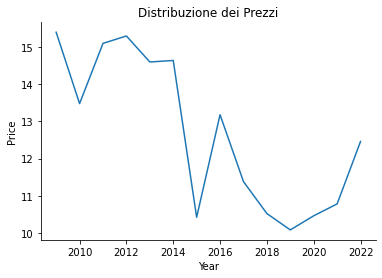

In [59]:
fig, ax = plt.subplots()
plt.plot(annual_price['Year'], annual_price['Price'])
plt.title("Distribuzione dei Prezzi")
plt.ylabel("Price")
plt.xlabel("Year")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Come si nota dal grafico il prezzo è molto variabile ma con una tendenza ad un prezzo più alto negli anni precedenti al 2014

<AxesSubplot:title={'center':'Price'}, xlabel='Year'>

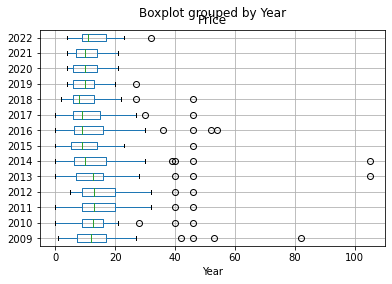

In [25]:
book.boxplot(column='Price', by='Year', vert = False)

Utilizzando anche un grafico boxplot vediamo come il range di prezzo è maggiore dal 2009 al 2014 per poi stabilizzarsi senza avere gap di prezzo troppo elevati

Una volta fatte queste considerazioni preliminari sul prezzo dei bestSeller vediamo se il genere incide su di esso:

In [26]:
book.groupby('Genre')[['Price']].mean().reset_index()

,Genre,Price
0,Fiction,10.663462
1,Non Fiction,14.337629


Il prezzo dei libri "Non Fiction" è più alto rispetto a quelli Fiction

<AxesSubplot:xlabel='Year', ylabel='Price'>

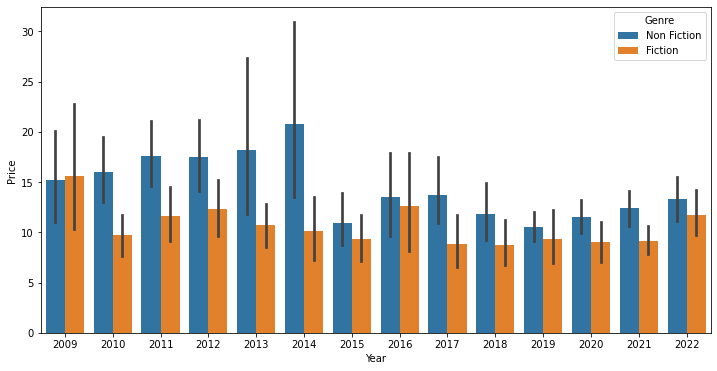

In [27]:
plt.figure(figsize=(12,6))
sb.barplot(data=book, x='Year', y='Price', hue='Genre')

Utilizzando la libreria seaborn che offre grafici molto precisi possiamo vedere come il prezzo dei libri "non fiction" è solitamente più alto rispetto a quello dei libri Fiction in ogni anno

LIBRI FICTION MENO IN VOGA PERCHE' PIU' COSTOSI??

Possiamo confermare quanto appena detto attraverso un T-test:

H0: i libri "Non Fiction" costano di più rispetto a quelli "Fiction"

H1:i libri "Non Fiction" costano di meno rispetto a quelli "Fiction"

In [28]:
t_statistic, p_value = stats.ttest_1samp(a= book['Price'][book['Genre']=="Fiction"], popmean= book['Price'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

-8.22729881310927
2.6502543689334234e-15


Usando sempre lo stesso intervallo di confidenza dello 0.95 vediamo come il livello di significatività è più basso del p-value e per questo posso accettare l'ipotesi H0

Dallo studio della correlazione vediamo inoltre come il prezzo non incide su il numero di reviews e user rating

## STUDIO DEGLI AUTORI

Ci sono autori che hanno venduto più di altri? che genere preferiscono?

In [29]:
Best_Author = book.groupby('Author')[['Name']].count().sort_values(by='Name', ascending=False).reset_index()
Top_10_Author = Best_Author.head(10)
Top_10_Author

,Author,Name
0,Gary Chapman,14
1,Jeff Kinney,14
2,Suzanne Collins,12
3,American Psychological Association,11
4,Rick Riordan,11
5,Eric Carle,10
6,Dr. Seuss,10
7,Dav Pilkey,9
8,Gallup,9
9,Don Miguel Ruiz,9


Gli autori che hanno avuto più libri nella categoria best seller di amazon dal 2009 al 2022 sono Jeff Kinney e Gary Chapman.

Andiamo a vedere che tipo di libri hanno scritto:

In [60]:
Kinney = book[book["Author"] == "Jeff Kinney"]
Kinney

,Name,Author,User Rating,Reviews,Price,Year,Genre
5,Diary of a Wimpy Kid: The Last Straw (Book 3),Jeff Kinney,4.8,3837,15,2009,Fiction
7,"Dog Days (Diary of a Wimpy Kid, Book 4) (Volum...",Jeff Kinney,4.8,3181,12,2009,Fiction
95,"The Ugly Truth (Diary of a Wimpy Kid, Book 5)",Jeff Kinney,4.8,3796,12,2010,Fiction
103,"Cabin Fever (Diary of a Wimpy Kid, Book 6)",Jeff Kinney,4.8,4505,0,2011,Fiction
193,"The Third Wheel (Diary of a Wimpy Kid, Book 7)",Jeff Kinney,4.7,6377,7,2012,Fiction
205,"Diary of a Wimpy Kid: Hard Luck, Book 8",Jeff Kinney,4.8,6812,0,2013,Fiction
254,Diary of a Wimpy Kid: The Long Haul,Jeff Kinney,4.8,6540,22,2014,Fiction
328,Old School (Diary of a Wimpy Kid #10),Jeff Kinney,4.8,6169,7,2015,Fiction
359,Double Down (Diary of a Wimpy Kid #11),Jeff Kinney,4.8,5118,20,2016,Fiction
432,The Getaway,Jeff Kinney,4.8,5836,0,2017,Fiction


In [61]:
Chapman = book[book["Author"] == "Gary Chapman"]
Chapman

,Name,Author,User Rating,Reviews,Price,Year,Genre
31,The Five Love Languages: How to Express Heartf...,Gary Chapman,4.6,803,9,2009,Non Fiction
77,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,4.7,3477,28,2010,Non Fiction
127,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,4.7,3477,28,2011,Non Fiction
174,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,4.7,3477,28,2012,Non Fiction
232,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,4.7,3477,28,2013,Non Fiction
279,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,4.7,3477,28,2014,Non Fiction
332,The 5 Love Languages: The Secret to Love that ...,Gary Chapman,4.8,25554,8,2015,Non Fiction
381,The 5 Love Languages: The Secret to Love that ...,Gary Chapman,4.8,25554,8,2016,Non Fiction
429,The 5 Love Languages: The Secret to Love that ...,Gary Chapman,4.8,25554,8,2017,Non Fiction
484,The 5 Love Languages: The Secret to Love that ...,Gary Chapman,4.8,25554,8,2018,Non Fiction


Come possiamo vedere mentre Kinney è l'autore che ha scritto più bestSeller di tipo fiction Gary chapman è quello che ha scritto più bestseller di tipo "non fiction" sebbene sembrerebbe sempre lo stesso libro ripetuto negli anni, con edizioni anche differenti

## IL TITOLO

I dati a nostra disposizione non sono molti, per questo dobbiamo cercare di utilizzare ogni informazione a nostra disposizione

Utilizziamo un dato qualitativo come il Nome, che a primo impatto sembrerebbe inutile se non per contrassegnare un elemento del dataset

Possiamo ad esempio vedere se ci sono parole nei titoli più amati che rendono un libro "vincente" portando il pubblico di amazon a comprarne una copia rispetto ad altri libri

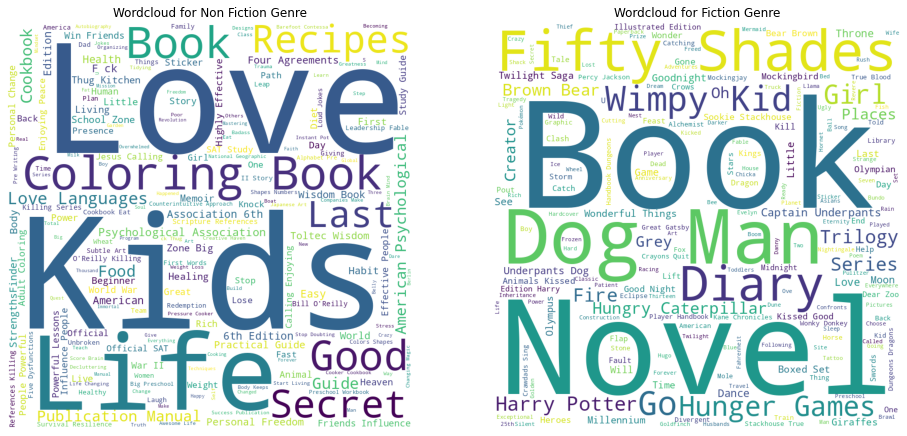

In [46]:
from wordcloud import WordCloud # wordcloud
fig, ax = plt.subplots(1, 2, figsize=(16,16))# plotting two subplots 
fict = WordCloud(background_color='white',width=800, height=800).generate(' '.join(book['Name'][book['Genre']=='Non Fiction']))
non_fict= WordCloud(background_color='white',width=800, height=800).generate(' '.join(book['Name'][book['Genre']=='Fiction']))
ax[0].imshow(wordcloud)
ax[0].axis('off')
ax[0].set_title('Wordcloud for Non Fiction Genre')

ax[1].imshow(wordcloud2)
ax[1].axis('off')
ax[1].set_title('Wordcloud for Fiction Genre')

plt.show()

## CONCLUSIONI

Dallo studio del dataset si è concluso come:
+ Il numero di reviews negli anni è salito vertiginosamente,a causa della pandemia
+ in generale c'è una preferenza verso i libri Non Fiction, anche se sembra che i bestseller di tipo Fiction abbiano venduto di più per il maggior numero di reviews
+ il prezzo medio dei bestseller è variato molto negli anni, ma il calo dei prezzi più significatuvo è stato quello a partire dal 2014 perchè prima di quell'anno i prezzi erano molto superiori alla media
+ in generale i libri Fiction hanno un prezzo superiore di alcuni euro